## Compute Sagnac Frequency - Plotting

## Imports

In [3]:
import os
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime

In [7]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [39]:
config = {}

config['seed'] = "BW.DROMY..FJZ"

## Easter
config['tbeg'] = UTCDateTime("2023-04-07 00:00")
config['tend'] = UTCDateTime("2023-04-10 00:00")

config['datapath'] = data_path+"sagnac_frequency/easter/"


## PRISM
config['tbeg'] = UTCDateTime("2023-05-04 00:00")
config['tend'] = UTCDateTime("2023-05-05 00:00")

config['datapath'] = data_path+"sagnac_frequency/prism/"


## Load Data

In [40]:
def __load_data(config):
    
    net, sta, loc, cha = config['seed'].split(".")
    
    t1 = date.fromisoformat(str(config['tbeg'].date))
    t2 = date.fromisoformat(str(config['tend'].date))

    df = DataFrame()
    for dat in date_range(t1,t2):
        file = cha+"_"+str(dat)[:10].replace("-","")+".pkl"

        try:
            df0 = read_pickle(config['datapath']+file)
            df = concat([df, df0])
        except:
            print(f"error for {config['datapath']}{file}")
            
    return df

In [41]:
config['seed'] = "BW.DROMY..FJZ"
fjz = __load_data(config)

config['seed'] = "BW.DROMY..F1V"
f1z = __load_data(config)

config['seed'] = "BW.DROMY..F4V"
f2z = __load_data(config)

error for /import/kilauea-data/sagnac_frequency/prism/FJZ_20230505.pkl
error for /import/kilauea-data/sagnac_frequency/prism/F1V_20230505.pkl
error for /import/kilauea-data/sagnac_frequency/prism/F4V_20230505.pkl


## Plot Frequency

In [52]:
def __makeplot(df1, df2, df3):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    time_scaling, time_unit = 1, "MJD"
    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
    ax[0].scatter(df1['times_mjd']/time_scaling, df1['freqs'], c="#3776ab", s=10, alpha=0.4, zorder=2, label="FJZ")
    ax[0].plot(df1['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df1['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)
    
    
    ## DF2
    ax[1].scatter(df2['times_mjd']/time_scaling, df2['freqs'], c="#f48512", s=10, alpha=0.4, zorder=2, label="F1Z")
    ax[1].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df2['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


    ## DF3
    ax[2].scatter(df2['times_mjd']/time_scaling, df3['freqs'], c="darkred", s=10, alpha=0.4, zorder=2, label="F2Z")
    ax[2].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df3['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


#     ax[2].set_ylim(5e12, 2e14)
        
#     ax[0].set_ylim(min(df1['freqs'][1:10]), max(df1['freqs'][1:10]))

    ax[0].set_ylim(553.48, 553.495)
    ax[1].set_ylim(553.48, 553.495)
    
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
    ax[2].ticklabel_format(useOffset=False, style='plain')
    
#     ymin, ymax = ax[0].axes.get_ylim()
#     ax[1].set_ylim(ymin, ymax)
#     ax[2].set_ylim(ymin, ymax)
    
    
    ax[0].set_ylabel(r"Sagnac Beat (Hz)", fontsize=font)
    ax[1].set_ylabel(r"CCW (Hz)", fontsize=font)
    ax[2].set_ylabel(r"CW (Hz)", fontsize=font)

    ax[2].set_xlabel("Days (MJD)", fontsize=font)
    
#     ax[0].set_title("ROMY-U Sagnac-Frequency", fontsize=font+2, pad=10)
    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    ax[2].legend(loc=4)
    
    for i in range(3):
        ax[i].grid(zorder=0)
    
    plt.show();

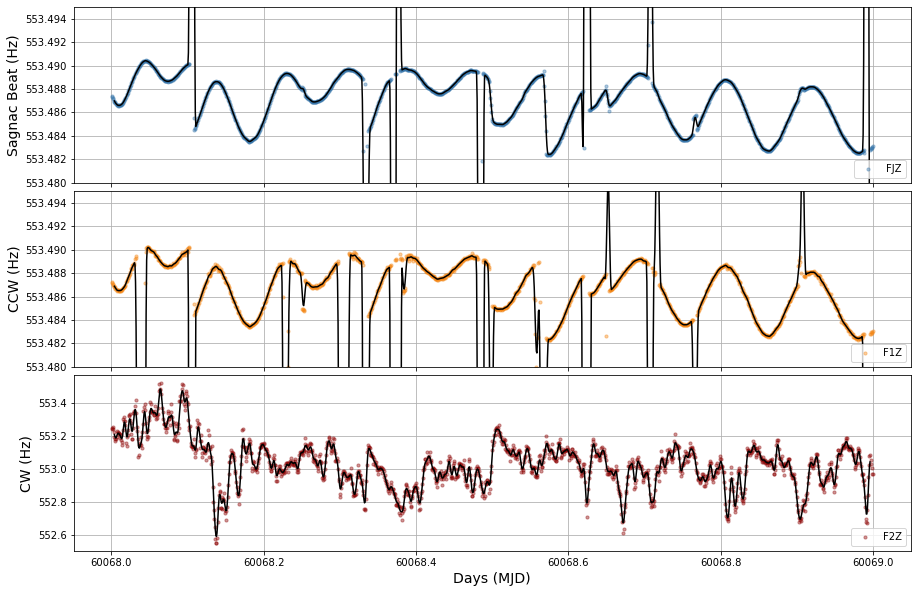

In [53]:
__makeplot(fjz, f1z, f2z)

## Cross-Correlation

In [37]:
def __makeplot_CC(df1, df2, df3):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    time_scaling, time_unit = 1, "MJD"
    
    
    from scipy import signal
    from numpy import mean, nanmax, correlate, argmax, arange
    
    s1 = fjz.freqs - mean(fjz.freqs)
    s2 = f1z.freqs - mean(f1z.freqs)
    s3 = f1z.freqs - mean(f1z.freqs)


    corr1 = correlate(s1, s2, mode='same')
    corr1 /= nanmax(corr1)

    corr2 = correlate(s1, s3, mode='same')
    corr2 /= nanmax(corr2)
    
    xlags1 = arange(-corr1.size//2, corr1.size//2, 1)
    xlags2 = arange(-corr2.size//2, corr2.size//2, 1)
    
    cc1_max_x = xlags1[argmax(corr1)]
    cc2_max_x = xlags2[argmax(corr2)]
    
    print(cc1_max_x, cc2_max_x)
    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=False)
    
#     plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
    ax[0].plot(df1['times_mjd']/time_scaling, df1['freqs'], c='k', alpha=0.4, zorder=2, label="FJZ")
    
    
    ## DF2
    ax[0].plot(df2['times_mjd']/time_scaling, df2['freqs'], c="#f48512", alpha=0.4, zorder=2, label="F1Z")


    ## DF3
    ax[0].plot(df2['times_mjd']/time_scaling, df3['freqs'], c="darkred", alpha=0.4, zorder=2, label="F2Z")


    ax[1].plot(xlags1, corr1, ls="--", label="FJZ-F1V")
    ax[1].plot(xlags2, corr2, ls=":", label="FJZ-F2V")
    

#     ax[0].set_ylim(553.462, 553.4725)
    
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')

    
    ax[0].set_ylabel(r"Sagnac Beat (Hz)", fontsize=font)
    ax[1].set_ylabel(r"CC", fontsize=font)

    ax[1].set_xlabel("Days (MJD)", fontsize=font)
    
#     ax[0].set_title("ROMY-U Sagnac-Frequency", fontsize=font+2, pad=10)
    ax[0].legend(loc=1)
    ax[1].legend(loc=1)
    
    for i in range(2):
        ax[i].grid(zorder=0)
    
    plt.show();

5 5


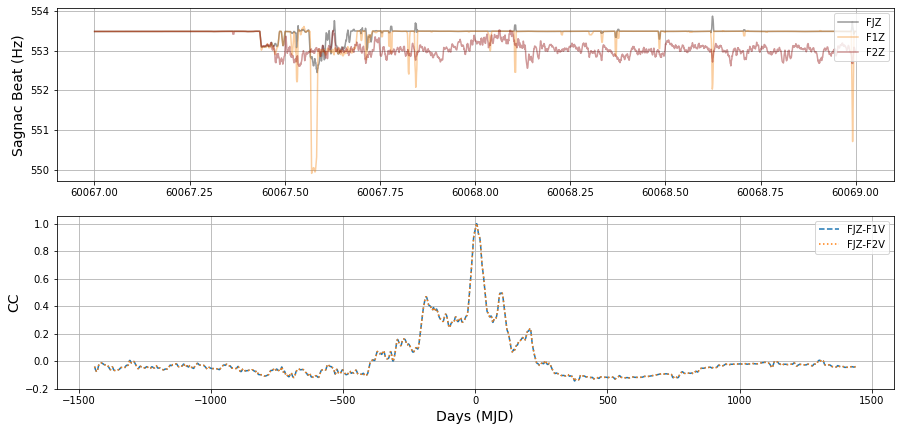

In [38]:
__makeplot_CC(fjz, f1z, f2z)

## Plot Power

In [35]:
def __makeplot_power(df1, df2, df3):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
    ax[0].scatter(df1['times_mjd'], df1['psd_max'], c="#3776ab", s=10, alpha=0.4, zorder=2, label="FJZ")
#     ax[0].plot(df1['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df1['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)
    
    
    ## DF2
    ax[1].scatter(df2['times_mjd'], df2['psd_max'], c="#f48512", s=10, alpha=0.4, zorder=2, label="F1Z*")
#     ax[1].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df2['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


    ## DF3
    ax[1].scatter(df2['times_mjd'], df3['psd_max'], c="darkred", s=10, alpha=0.4, zorder=2, label="F2Z")
#     ax[1].plot(df2['times_mjd'][cut_off:-cut_off]/time_scaling, __smooth(df3['freqs'],smooting)[cut_off:-cut_off], "k", zorder=2)


#     ax[2].set_ylim(5e12, 2e14)
        
#     ax[0].set_ylim(min(df1['freqs'][1:10]), max(df1['freqs'][1:10]))

#     ax[0].set_ylim(553.4550, 553.4655)
    
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
       
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    
    ax[0].set_ylabel(r"PSD$_{max}$", fontsize=font)
    ax[1].set_ylabel(r"PSD$_{max}$", fontsize=font)

    ax[1].set_xlabel("Days (MJD)", fontsize=font)
    
#     ax[0].set_title("ROMY-U Sagnac-Frequency", fontsize=font+2, pad=10)
    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    
    for i in range(2):
        ax[i].grid(zorder=0)
    
    plt.show();

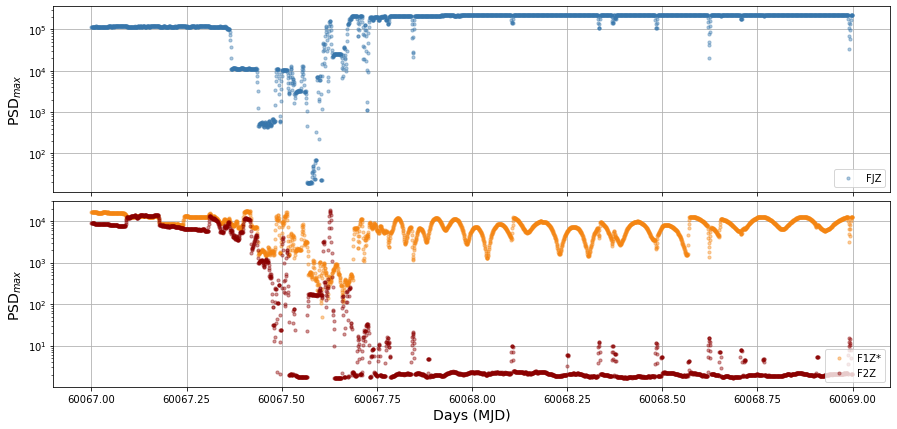

In [36]:
__makeplot_power(fjz, f1z, f2z)